In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Training and deploying a tabular model using Vertex custom training job

![Training pipeline](../images/custom-tabular.png)

## Install required packages

In [ ]:
%%bash
pip install --user google-cloud-aiplatform
pip install --user kfp
pip install --user google-cloud-pipeline-components
pip install --user google-cloud-bigquery-datatransfer

### Restart the kernel
Once you've installed the required packages, you need to restart the notebook kernel so it can find the packages.

In [ ]:
# Automatically restart kernel after installs
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

## Import the required packages

In [224]:
import os
import pprint
import pandas as pd
import tensorflow as tf
import time
import csv
from datetime import datetime

import matplotlib.pyplot as plt

import google.auth
from google.protobuf.json_format import MessageToDict

from google.cloud import aiplatform as vertex_ai
from google.cloud.aiplatform import hyperparameter_tuning as hpt
from google.cloud.aiplatform_v1beta1 import types
from google.cloud import bigquery
from google.cloud import exceptions

from google.cloud.aiplatform.utils import JobClientWithOverride

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow_io import bigquery as tfio_bq

## Configure GCP settings

*Before running the notebook make sure to follow the repo's README file to install the pre-requisites.*

In [17]:
creds, PROJECT = google.auth.default()
REGION = 'us-central1'
PREFIX = 'rtvw'            # <--- CHANGE THIS TO VARIABLE YOU SET UP DURING PREREQUISITES

STAGING_BUCKET = f'gs://{PREFIX}-{PROJECT}-bucket'
VERTEX_SA = f'training-sa@{PROJECT}.iam.gserviceaccount.com'

print(f"PROJECT = {PROJECT}")
print(f"STAGING_BUCKET = {STAGING_BUCKET}")
print(f"VERTEX_SA = {VERTEX_SA}")

# get tensorboard instance
shell_output = !gcloud beta ai tensorboards list --region $REGION --filter=displayName:$PREFIX-$REGION-tensorboard --format='value(name)' --quiet 2>/dev/null
TENSORBOARD = shell_output[-1]
print(f"TENSORBOARD = {TENSORBOARD}")

PROJECT = rt-vertex-sandbox
STAGING_BUCKET = gs://rtvw-rt-vertex-sandbox-bucket
VERTEX_SA = training-sa@rt-vertex-sandbox.iam.gserviceaccount.com
TENSORBOARD = projects/437422844431/locations/us-central1/tensorboards/6509988445736140800


## Preparing training data in BigQuery

### Explore Chicago Taxi dataset

In [18]:
%%bigquery data

SELECT 
    *
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
LIMIT 3

Downloading: 100%|██████████| 3/3 [00:02<00:00,  1.37rows/s]


In [19]:
data.head().T

,0,1,2
unique_key,afdb4903f8cbe066868d90c06b01449f58052462,a9488bef4cecbda3c212a6ebcd261ba26749df36,dcbbad2d636c999ef7fe5bbda536fb5ee3b84f8a
taxi_id,4399985da5ca143d850858bc197bf4a744366cfc19bb86...,68d140be0fa68d84f89f8ef45edca6eafd824b0bc30660...,dfdb89329a6bd26bb76e1d13bcac71b813d6bd3c9f3439...
trip_start_timestamp,2015-07-03 01:15:00+00:00,2015-10-04 01:30:00+00:00,2015-06-18 21:00:00+00:00
trip_end_timestamp,2015-07-03 01:15:00+00:00,2015-10-04 01:30:00+00:00,2015-06-18 21:00:00+00:00
trip_seconds,0,0,0
trip_miles,0.0,0.0,0.0
pickup_census_tract,NaN,NaN,NaN
dropoff_census_tract,NaN,NaN,NaN
pickup_community_area,NaN,NaN,NaN
dropoff_community_area,NaN,NaN,NaN


In [22]:
%%bigquery data

SELECT 
    CAST(EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS string) AS trip_dayofweek, 
    FORMAT_DATE('%A',cast(trip_start_timestamp as date)) AS trip_dayname,
    COUNT(*) as trip_count,
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
    EXTRACT(YEAR FROM trip_start_timestamp) = 2020 
GROUP BY
    trip_dayofweek,
    trip_dayname
ORDER BY
    trip_dayofweek

Downloading: 100%|██████████| 7/7 [00:01<00:00,  6.03rows/s]


In [23]:
data

,trip_dayofweek,trip_dayname,trip_count
0,1,Sunday,334984
1,2,Monday,548213
2,3,Tuesday,599434
3,4,Wednesday,646244
4,5,Thursday,686346
5,6,Friday,667116
6,7,Saturday,406695


<AxesSubplot:xlabel='trip_dayname'>

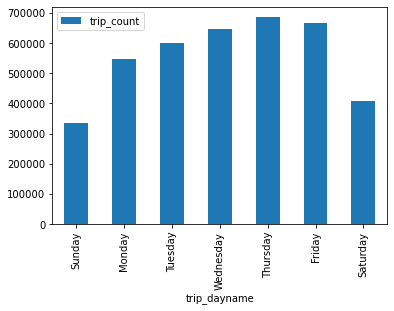

In [24]:
data.plot(kind='bar', x='trip_dayname', y='trip_count')

### Create  data splits

In [25]:
BQ_DATASET_NAME = f'{PREFIX}_dataset' 
BQ_TRAIN_SPLIT_NAME = 'training'
BQ_VALID_SPLIT_NAME = 'validation'
BQ_TEST_SPLIT_NAME = 'testing'
BQ_LOCATION = 'US'
SAMPLE_SIZE = 500000
YEAR = 2020

#### Create a BQ dataset to host the splits

In [26]:
client = bigquery.Client(location=BQ_LOCATION)

dataset_id = f'{PROJECT}.{BQ_DATASET_NAME}'
dataset = bigquery.Dataset(dataset_id)

try:
    dataset = client.create_dataset(dataset, timeout=30)
    print('Created dataset: ', dataset_id)
except exceptions.Conflict:
    print('Dataset {} already exists'.format(dataset_id))

Dataset rt-vertex-sandbox.rtvw_dataset already exists


#### Create training, validation, and test splits tables

In [27]:
sql_script_template = '''
CREATE TEMP TABLE features 
AS (
    WITH
      taxitrips AS (
      SELECT
        FORMAT_DATETIME('%Y-%d-%m', trip_start_timestamp) AS date,
        trip_start_timestamp,
        trip_seconds,
        trip_miles,
        payment_type,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude,
        tips,
        fare
      FROM
        `bigquery-public-data.chicago_taxi_trips.taxi_trips`
      WHERE 1=1 
      AND pickup_longitude IS NOT NULL
      AND pickup_latitude IS NOT NULL
      AND dropoff_longitude IS NOT NULL
      AND dropoff_latitude IS NOT NULL
      AND trip_miles > 0
      AND trip_seconds > 0
      AND fare > 0
      AND EXTRACT(YEAR FROM trip_start_timestamp) = @YEAR
    )

    SELECT
      trip_start_timestamp,
      EXTRACT(MONTH from trip_start_timestamp) as trip_month,
      EXTRACT(DAY from trip_start_timestamp) as trip_day,
      EXTRACT(DAYOFWEEK from trip_start_timestamp) as trip_day_of_week,
      EXTRACT(HOUR from trip_start_timestamp) as trip_hour,
      trip_seconds,
      trip_miles,
      payment_type,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(pickup_longitude, pickup_latitude), 0.1)
      ) AS pickup_grid,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(dropoff_longitude, dropoff_latitude), 0.1)
      ) AS dropoff_grid,
      ST_Distance(
          ST_GeogPoint(pickup_longitude, pickup_latitude), 
          ST_GeogPoint(dropoff_longitude, dropoff_latitude)
      ) AS euclidean,
      IF((tips/fare >= 0.2), 1, 0) AS tip_bin,
      CASE (ABS(MOD(FARM_FINGERPRINT(date),10))) 
          WHEN 9 THEN 'TEST'
          WHEN 8 THEN 'VALIDATE'
          ELSE 'TRAIN' END AS data_split
    FROM
      taxitrips
    LIMIT @LIMIT
);

CREATE OR REPLACE TABLE `@PROJECT.@DATASET.@TRAIN_SPLIT`
AS
SELECT * EXCEPT (trip_start_timestamp, data_split)
FROM features
WHERE data_split='TRAIN';

CREATE OR REPLACE TABLE `@PROJECT.@DATASET.@VALIDATE_SPLIT`
AS
SELECT * EXCEPT (trip_start_timestamp, data_split)
FROM features
WHERE data_split='VALIDATE';

CREATE OR REPLACE TABLE `@PROJECT.@DATASET.@TEST_SPLIT`
AS
SELECT * EXCEPT (trip_start_timestamp, data_split)
FROM features
WHERE data_split='TEST';

DROP TABLE features;
'''

In [28]:
sql_script = sql_script_template.replace(
    '@PROJECT', PROJECT).replace(
    '@DATASET', BQ_DATASET_NAME).replace(
    '@TRAIN_SPLIT', BQ_TRAIN_SPLIT_NAME).replace(
    '@VALIDATE_SPLIT', BQ_VALID_SPLIT_NAME).replace(
    '@TEST_SPLIT', BQ_TEST_SPLIT_NAME).replace(
    '@YEAR', str(YEAR)).replace(
    '@LIMIT', str(SAMPLE_SIZE))

job = client.query(sql_script)
job.result()    

#### Review splits

In [29]:
sql_script = f'''
SELECT * 
FROM `{PROJECT}.{BQ_DATASET_NAME}.{BQ_TRAIN_SPLIT_NAME}`
'''

data = client.query(sql_script).to_dataframe()

In [30]:
data.head()

,trip_month,trip_day,trip_day_of_week,trip_hour,trip_seconds,trip_miles,payment_type,pickup_grid,dropoff_grid,euclidean,tip_bin
0,2,1,7,8,165,0.62,Cash,POINT(-87.7 42),POINT(-87.7 42),0.0,0
1,2,1,7,16,360,1.00,Cash,POINT(-87.6 41.9),POINT(-87.6 41.9),0.0,0
2,2,1,7,19,720,0.10,Credit Card,POINT(-87.7 41.9),POINT(-87.7 41.9),0.0,0
3,2,1,7,2,126,0.17,Credit Card,POINT(-87.7 41.9),POINT(-87.7 41.9),0.0,0
4,2,1,7,18,292,0.29,Cash,POINT(-87.7 41.9),POINT(-87.7 41.9),0.0,0


## Submitting Vertex training jobs

![Training pipeline](../images/custom-training-on-vertex-ai.png)

### Display the model

`tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")`

![Model](model.png)

### Prepare a training script

In [186]:
SCRIPT_FOLDER = 'trainer'
if tf.io.gfile.exists(SCRIPT_FOLDER):
    tf.io.gfile.rmtree(SCRIPT_FOLDER)
tf.io.gfile.mkdir(SCRIPT_FOLDER)
file_path = os.path.join(SCRIPT_FOLDER, 'train.py')

In [187]:
%%writefile {file_path}

# Copyright 2021 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#            http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and

import hypertune
import json
import os
import re
import tensorflow as tf

from absl import app
from absl import flags
from absl import logging

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow_io import bigquery as tfio_bq

from tensorboard.plugins.hparams import api as tb_hp

FLAGS = flags.FLAGS
flags.DEFINE_integer('epochs', 3, 'Nubmer of epochs')
flags.DEFINE_integer('units', 32, 'Number units in a hidden layer')
flags.DEFINE_integer('per_replica_batch_size', 128, 'Per replica batch size')
flags.DEFINE_float('dropout_ratio', 0.5, 'Dropout ratio')
flags.DEFINE_string('training_table', None, 'Training table name')
flags.DEFINE_string('validation_table', None, 'Validationa table name')
flags.mark_flag_as_required('training_table')
flags.mark_flag_as_required('validation_table')

LOCAL_MODEL_DIR = '/tmp/saved_model'
LOCAL_TB_DIR = '/tmp/logs'
LOCAL_CHECKPOINT_DIR = '/tmp/checkpoints'
EVALUATION_FILE_NAME = 'evaluations.json'

# Define features
FEATURES = {
    "tip_bin": ("categorical", tf.int64),
    "trip_month": ("categorical", tf.int64),
    "trip_day": ("categorical", tf.int64),
    "trip_day_of_week": ("categorical", tf.int64),
    "trip_hour": ("categorical", tf.int64),
    "payment_type": ("categorical", tf.string),
    "pickup_grid": ("categorical", tf.string),
    "dropoff_grid": ("categorical", tf.string),
    "euclidean": ("numeric", tf.double),
    "trip_seconds": ("numeric", tf.int64),
    "trip_miles": ("numeric", tf.double),
}
TARGET_FEATURE_NAME = 'tip_bin'

 # Set hparams for Tensorboard and Vertex hp tuner
HP_DROPOUT = tb_hp.HParam("dropout")
HP_UNITS = tb_hp.HParam("units")
HPARAMS = [
    HP_UNITS,
    HP_DROPOUT,
]
METRICS = [
    tb_hp.Metric(
        "epoch_accuracy",
        group="validation",
        display_name="epoch accuracy"),
]
HPTUNE_METRIC = 'val_accuracy'
    

def set_job_dirs():
    """Sets job directories and hyperparameter tuning trial id
    based on env variables set by Vertex AI."""
    
    model_dir = os.getenv('AIP_MODEL_DIR', LOCAL_MODEL_DIR)
    tb_dir = os.getenv('AIP_TENSORBOARD_LOG_DIR', LOCAL_TB_DIR)
    checkpoint_dir = os.getenv('AIP_CHECKPOINT_DIR', LOCAL_CHECKPOINT_DIR)
    
    path = os.path.normpath(tb_dir)
    trial_id = re.match('^[0-9]+$', path.split(os.sep)[-2])
    if not trial_id:
        trial_id = '0'
    else:
        trial_id = trial_id[0]
    logging.info(trial_id)
    
    return model_dir, tb_dir, checkpoint_dir, trial_id


def get_bq_dataset(table_name, selected_fields, target_feature='tip_bin', batch_size=32):
    
    def _transform_row(row_dict):
        trimmed_dict = {column:
                       (tf.strings.strip(tensor) if tensor.dtype == 'string' else tensor) 
                       for (column,tensor) in row_dict.items()
                       }
        target = trimmed_dict.pop(target_feature)
        return (trimmed_dict, target)

    project_id, dataset_id, table_id = table_name.split('.')
    
    client = tfio_bq.BigQueryClient()
    parent = f'projects/{project_id}'

    read_session = client.read_session(
        parent=parent,
        project_id=project_id,
        table_id=table_id,
        dataset_id=dataset_id,
        selected_fields=selected_fields,
    )

    dataset = read_session.parallel_read_rows().map(_transform_row).batch(batch_size)
    
    return dataset


def get_category_encoding_layer(name, dataset, dtype):
    """Creates a CategoryEncoding layer for a given feature."""

    if dtype == tf.string:
      index = preprocessing.StringLookup()
    else:
      index = preprocessing.IntegerLookup()

    feature_ds = dataset.map(lambda x, y: x[name])
    index.adapt(feature_ds)
    encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

    return lambda feature: encoder(index(feature))


def get_normalization_layer(name, dataset):
  """"Creates a Normalization layer for a given feature."""
  normalizer = preprocessing.Normalization()

  feature_ds = dataset.map(lambda x, y: x[name])
  normalizer.adapt(feature_ds)

  return normalizer


def create_model(dataset, input_features, units, dropout_ratio):
    """Creates a binary classifier for Chicago Taxi tip prediction task."""
    
    all_inputs = []
    encoded_features = []
    for feature_name, feature_info in input_features.items():
        col = tf.keras.Input(shape=(1,), name=feature_name, dtype=feature_info[1])
        if feature_info[0] == 'categorical':
            
            encoding_layer = get_category_encoding_layer(feature_name, 
                                                         dataset,
                                                         feature_info[1])
        else:
            encoding_layer = get_normalization_layer(feature_name,
                                                     dataset) 
        encoded_col = encoding_layer(col)
        all_inputs.append(col)
        encoded_features.append(encoded_col)
        
    all_features = tf.keras.layers.concatenate(encoded_features)
    
    x = tf.keras.layers.Dense(units, activation="relu")(all_features)
    x = tf.keras.layers.Dropout(dropout_ratio)(x)
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(all_inputs, output)
    
    return model


class HptuneCallback(tf.keras.callbacks.Callback):
    """
    A custom Keras callback class that reports a metric to hypertuner
    at the end of each epoch.
    """
    
    def __init__(self, metric_tag, metric_value):
        super(HptuneCallback, self).__init__()
        self.metric_tag = metric_tag
        self.metric_value = metric_value
        self.hpt = hypertune.HyperTune()
        
    def on_epoch_end(self, epoch, logs=None):
        self.hpt.report_hyperparameter_tuning_metric(
            hyperparameter_metric_tag=self.metric_tag,
            metric_value=logs[self.metric_value],
            global_step=epoch)
        

def main(argv):
    del argv
    
    # Set distribution strategy
    strategy = tf.distribute.MirroredStrategy()
    
    global_batch_size = (strategy.num_replicas_in_sync *
                         FLAGS.per_replica_batch_size)
    
    # Prepare datasets
    selected_fields = {key: {'output_type': value[1]} for key, value in FEATURES.items()}
    validation_ds = get_bq_dataset(FLAGS.validation_table, 
                                   selected_fields, 
                                   batch_size=global_batch_size)
    training_ds = get_bq_dataset(FLAGS.training_table,
                                 selected_fields,
                                 batch_size=global_batch_size)
    
    # Configure Tensorboard hparams
    model_dir, tb_dir, checkpoint_dir, trial_id = set_job_dirs()
    with tf.summary.create_file_writer(tb_dir).as_default():
        tb_hp.hparams_config(hparams=HPARAMS, metrics=METRICS)
        
    hparams = {
        HP_UNITS: FLAGS.units,
        HP_DROPOUT: FLAGS.dropout_ratio
    }
    
    # Create the model
    input_features = {key: value for key, value in FEATURES.items() if key != TARGET_FEATURE_NAME}
    logging.info('Creating the model ...')
    with strategy.scope():
        model = create_model(training_ds, input_features, hparams[HP_UNITS], hparams[HP_DROPOUT])
        model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    # Configure training regimen
    callbacks = [tf.keras.callbacks.experimental.BackupAndRestore(backup_dir=checkpoint_dir)]
    callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                                    update_freq='batch',
                                                    profile_batch=0))
    callbacks.append(tb_hp.KerasCallback(writer=tb_dir, 
                                         hparams=hparams,
                                         trial_id=trial_id))
    callbacks.append(HptuneCallback(HPTUNE_METRIC, HPTUNE_METRIC))
    
    # Start training
    logging.info('Starting training ...')
    history = model.fit(training_ds, 
              epochs=FLAGS.epochs, 
              validation_data=validation_ds,
              callbacks=callbacks)
    
    # Save trained model
    logging.info('Training completed. Saving the trained model to: {}'.format(model_dir))
    model.save(model_dir)  
    
    
if __name__ == '__main__':
    logging.set_verbosity(logging.INFO)
    app.run(main)

Writing trainer/train.py


### Initialize Vertex AI SDK and Set an Experiment

Define experiment name.

In [38]:
EXPERIMENT_NAME = "chicago-taxi-tips-classifier"  # @param {type:"string"}

If EXPERIMENT_NAME is not set, set a default one below:

In [34]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

In [35]:
if EXPERIMENT_NAME == "" or EXPERIMENT_NAME is None:
    EXPERIMENT_NAME = "my-experiment-" + TIMESTAMP

In [39]:
vertex_ai.init(
    project=PROJECT,
    location=REGION,
    staging_bucket=STAGING_BUCKET,
    experiment=EXPERIMENT_NAME
)

INFO:root:Resource chicago-taxi-tips-classifier not found.
INFO:root:Creating Resource chicago-taxi-tips-classifier


### Configure and submit a custom Vertex job using a script

In [42]:
job_name = f"chicago-taxi-clsfr-custom-{TIMESTAMP}"
base_output_dir = f'{STAGING_BUCKET}/jobs/{job_name}'

epochs = 2
batch_size = 128

#container_uri = 'us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-4:latest'
container_uri = 'us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-4:latest'
requirements = ['tensorflow-datasets==4.3.0']
args = [
    f'--epochs={epochs}', 
    f'--per_replica_batch_size={batch_size}',
    '--training_table=' + f'{PROJECT}.{BQ_DATASET_NAME}.{BQ_TRAIN_SPLIT_NAME}',
    '--validation_table=' + f'{PROJECT}.{BQ_DATASET_NAME}.{BQ_TRAIN_SPLIT_NAME}',
]

machine_type = 'n1-standard-4'
#accelerator_type = 'NVIDIA_TESLA_T4'
#accelerator_count = 1

job = vertex_ai.CustomJob.from_local_script(
    display_name=job_name,
    machine_type=machine_type,
#    accelerator_type=accelerator_type,
#    accelerator_count=accelerator_count,
    script_path='trainer/train.py',
    container_uri=container_uri,
    requirements=requirements,
    args=args,
    staging_bucket=base_output_dir
)


vertex_ai.start_run("custom-training-run-1")  # Change this to your desired run name
parameters = {"epochs": 2, 
              "batch_size": 128,
              "training_table": f'{PROJECT}.{BQ_DATASET_NAME}.{BQ_TRAIN_SPLIT_NAME}',
              "validation_table": f'{PROJECT}.{BQ_DATASET_NAME}.{BQ_TRAIN_SPLIT_NAME}'
             }
vertex_ai.log_params(parameters)

INFO:google.cloud.aiplatform.utils.source_utils:Training script copied to:
gs://rtvw-rt-vertex-sandbox-bucket/jobs/chicago-taxi-clsfr-custom-20210620155233/aiplatform-2021-06-20-16:04:44.701-aiplatform_custom_trainer_script-0.1.tar.gz.


In [43]:
job.run(sync=False, 
        service_account=VERTEX_SA,
        tensorboard=TENSORBOARD,
        )

INFO:google.cloud.aiplatform.jobs:Creating CustomJob
INFO:google.cloud.aiplatform.jobs:CustomJob created. Resource name: projects/437422844431/locations/us-central1/customJobs/8371527602258575360
INFO:google.cloud.aiplatform.jobs:To use this CustomJob in another session:
INFO:google.cloud.aiplatform.jobs:custom_job = aiplatform.CustomJob.get('projects/437422844431/locations/us-central1/customJobs/8371527602258575360')
INFO:google.cloud.aiplatform.jobs:View Custom Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/8371527602258575360?project=437422844431
INFO:google.cloud.aiplatform.jobs:View Tensorboard:
https://us-central1.tensorboard.googleusercontent.com/experiment/projects+437422844431+locations+us-central1+tensorboards+6509988445736140800+experiments+8371527602258575360
INFO:google.cloud.aiplatform.jobs:CustomJob projects/437422844431/locations/us-central1/customJobs/8371527602258575360 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aipla

In [44]:
print(f"Job Name: {job.display_name}")
print(f"Job Resource Name: {job.resource_name}\n")
print(f"Check training progress at {job._dashboard_uri()}")

Job Name: chicago-taxi-clsfr-custom-20210620155233
Job Resource Name: projects/437422844431/locations/us-central1/customJobs/8371527602258575360

Check training progress at https://console.cloud.google.com/ai/platform/locations/us-central1/training/8371527602258575360?project=437422844431


Check model artifacts in GCS bucket

In [51]:
!gsutil ls $base_output_dir/model/

gs://rtvw-rt-vertex-sandbox-bucket/jobs/chicago-taxi-clsfr-custom-20210620155233/model/
gs://rtvw-rt-vertex-sandbox-bucket/jobs/chicago-taxi-clsfr-custom-20210620155233/model/saved_model.pb
gs://rtvw-rt-vertex-sandbox-bucket/jobs/chicago-taxi-clsfr-custom-20210620155233/model/assets/
gs://rtvw-rt-vertex-sandbox-bucket/jobs/chicago-taxi-clsfr-custom-20210620155233/model/variables/


Model artifacts to be deployed to Vertex Model Resource later in the notebook

### Configure and submit a Vertex job using a custom container

#### Create a Dockerfile

In [53]:
BASE_IMAGE = 'gcr.io/deeplearning-platform-release/tf2-cpu.2-4'
TRAIN_IMAGE = f'gcr.io/{PROJECT}/{PREFIX}_chicago_taxi_clsfr_trainer'

dockerfile = f'''
FROM {BASE_IMAGE}

WORKDIR /trainer
RUN pip install cloudml-hypertune

# Copies the trainer code to the docker image.
COPY train.py .

ENTRYPOINT ["python", "train.py"]
'''

with open(os.path.join(SCRIPT_FOLDER, 'Dockerfile'), 'w') as f:
    f.write(dockerfile)

#### Build a container image

In [54]:
!gcloud builds submit --tag {TRAIN_IMAGE} {SCRIPT_FOLDER}

Creating temporary tarball archive of 2 file(s) totalling 9.0 KiB before compression.
Uploading tarball of [trainer] to [gs://rt-vertex-sandbox_cloudbuild/source/1624231954.886997-44d1f8689a6442f0b8342b492d52f129.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/rt-vertex-sandbox/locations/global/builds/c0405476-7334-4bc5-a091-0b9210469c9a].
Logs are available at [https://console.cloud.google.com/cloud-build/builds/c0405476-7334-4bc5-a091-0b9210469c9a?project=437422844431].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "c0405476-7334-4bc5-a091-0b9210469c9a"

FETCHSOURCE
Fetching storage object: gs://rt-vertex-sandbox_cloudbuild/source/1624231954.886997-44d1f8689a6442f0b8342b492d52f129.tgz#1624231955632060
Copying gs://rt-vertex-sandbox_cloudbuild/source/1624231954.886997-44d1f8689a6442f0b8342b492d52f129.tgz#1624231955632060...
/ [1 files][  3.4 KiB/  3.4 KiB]                                                
Operation completed 

#### Prepare worker pool specification

In [57]:
epochs = 2
batch_size = 128

worker_pool_specs =  [
    {
        "machine_spec": {
            "machine_type": "n1-standard-4",
#            "accelerator_type": "NVIDIA_TESLA_V100",
#            "accelerator_count": 1,
        },
        "replica_count": 1,
        "container_spec": {
            "image_uri": TRAIN_IMAGE,
#            "command": ["python", "train.py"],
            "args": [
                f'--epochs={epochs}', 
                f'--per_replica_batch_size={batch_size}',
                '--training_table=' + f'{PROJECT}.{BQ_DATASET_NAME}.{BQ_TRAIN_SPLIT_NAME}',
                '--validation_table=' + f'{PROJECT}.{BQ_DATASET_NAME}.{BQ_VALID_SPLIT_NAME}',
            ],
        },
    }
]

#### Submit and monitor the job

In [59]:
job_name = f"chicago-taxi-clsfr-custom-{time.strftime('%Y%m%d_%H%M%S')}"

job = vertex_ai.CustomJob(
    display_name=job_name,
    worker_pool_specs=worker_pool_specs,
    staging_bucket=f'{STAGING_BUCKET}/{job_name}'
)

vertex_ai.start_run("custom-training-run-2")  # Change this to your desired run name
parameters = {"epochs": epochs, 
              "batch_size": batch_size,
              "training_table": f'{PROJECT}.{BQ_DATASET_NAME}.{BQ_TRAIN_SPLIT_NAME}',
              "validation_table": f'{PROJECT}.{BQ_DATASET_NAME}.{BQ_TRAIN_SPLIT_NAME}'
             }
vertex_ai.log_params(parameters)

INFO:root:Resource chicago-taxi-tips-classifier-custom-training-run-2 not found.
INFO:root:Creating Resource chicago-taxi-tips-classifier-custom-training-run-2
INFO:root:Resource chicago-taxi-tips-classifier-custom-training-run-2-metrics not found.
INFO:root:Creating Resource chicago-taxi-tips-classifier-custom-training-run-2-metrics


In [60]:
job.run(sync=False, 
        service_account=VERTEX_SA,
        tensorboard=TENSORBOARD
)

INFO:google.cloud.aiplatform.jobs:Creating CustomJob
INFO:google.cloud.aiplatform.jobs:CustomJob created. Resource name: projects/437422844431/locations/us-central1/customJobs/4977502333081485312
INFO:google.cloud.aiplatform.jobs:To use this CustomJob in another session:
INFO:google.cloud.aiplatform.jobs:custom_job = aiplatform.CustomJob.get('projects/437422844431/locations/us-central1/customJobs/4977502333081485312')
INFO:google.cloud.aiplatform.jobs:View Custom Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/4977502333081485312?project=437422844431
INFO:google.cloud.aiplatform.jobs:View Tensorboard:
https://us-central1.tensorboard.googleusercontent.com/experiment/projects+437422844431+locations+us-central1+tensorboards+6509988445736140800+experiments+4977502333081485312


In [61]:
print(f"Job Name: {job.display_name}")
print(f"Job Resource Name: {job.resource_name}\n")
print(f"Check training progress at {job._dashboard_uri()}")

Job Name: chicago-taxi-clsfr-custom-20210620_235910
Job Resource Name: projects/437422844431/locations/us-central1/customJobs/4977502333081485312

Check training progress at https://console.cloud.google.com/ai/platform/locations/us-central1/training/4977502333081485312?project=437422844431
INFO:google.cloud.aiplatform.jobs:CustomJob projects/437422844431/locations/us-central1/customJobs/4977502333081485312 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:CustomJob projects/437422844431/locations/us-central1/customJobs/4977502333081485312 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:CustomJob projects/437422844431/locations/us-central1/customJobs/4977502333081485312 current state:
JobState.JOB_STATE_PENDING


In [62]:
!gsutil ls {STAGING_BUCKET}/{job_name}

CommandException: One or more URLs matched no objects.
INFO:google.cloud.aiplatform.jobs:CustomJob projects/437422844431/locations/us-central1/customJobs/4977502333081485312 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:CustomJob projects/437422844431/locations/us-central1/customJobs/4977502333081485312 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:CustomJob projects/437422844431/locations/us-central1/customJobs/4977502333081485312 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:CustomJob projects/437422844431/locations/us-central1/customJobs/4977502333081485312 current state:
JobState.JOB_STATE_RUNNING


### Configure and submit a Hyperparameter Tuning job

In [66]:
epochs = 5
batch_size = 128

# The spec of the worker pools including machine type and Docker image
# Be sure to replace IMAGE_URI with the path to your Docker image in GCR
worker_pool_specs = [{
    "machine_spec": {
        "machine_type": "n1-standard-4",
      #  "accelerator_type": vertex_ai.gapic.AcceleratorType.NVIDIA_TESLA_T4,
      #  "accelerator_count": 1,
    },
    "replica_count": 1,
    "container_spec": {
        "image_uri": TRAIN_IMAGE,
        "args": [
            f'--epochs={epochs}', 
            f'--per_replica_batch_size={batch_size}',
            '--training_table=' + f'{PROJECT}.{BQ_DATASET_NAME}.{BQ_TRAIN_SPLIT_NAME}',
            '--validation_table=' + f'{PROJECT}.{BQ_DATASET_NAME}.{BQ_VALID_SPLIT_NAME}',
        ],
    },
}]

# Dicionary representing metrics to optimize.
# The dictionary key is the metric_id, which is reported by your training job,
# And the dictionary value is the optimization goal of the metric.
metric_spec={'val_accuracy':'maximize'}

# Dictionary representing parameters to optimize.
# The dictionary key is the parameter_id, which is passed into your training
# job as a command line argument,
# And the dictionary value is the parameter specification of the metric.
parameter_spec = {
    "units": hpt.DiscreteParameterSpec(values=[32, 64], scale=None),
    "dropout_ratio": hpt.DoubleParameterSpec(min=0.4, max=0.6, scale="linear")
}

#### Configure custom job

In [67]:
TIMESTAMP = time.strftime('%Y%m%d_%H%M%S')

In [68]:
job_name = f"chicago-taxi-clsfr-custom-hp-{TIMESTAMP}"

job = vertex_ai.CustomJob(
    display_name=job_name,
    worker_pool_specs=worker_pool_specs,
    staging_bucket=f'{STAGING_BUCKET}/{job_name}'
)

#### Create and run Hyperparameter Tuning job

In [70]:
hp_job_name = f"chicago-taxi-clsfr-hptuning-{TIMESTAMP}"

hp_job = vertex_ai.HyperparameterTuningJob(
    display_name=hp_job_name,
    custom_job=job,
    metric_spec=metric_spec,
    parameter_spec=parameter_spec,
    max_trial_count=3,
    parallel_trial_count=3,
    max_failed_trial_count=1
)

In [71]:
hp_job.run(sync=False, 
        service_account=VERTEX_SA,
        tensorboard=TENSORBOARD
)

INFO:google.cloud.aiplatform.jobs:Creating HyperparameterTuningJob
INFO:google.cloud.aiplatform.jobs:HyperparameterTuningJob created. Resource name: projects/437422844431/locations/us-central1/hyperparameterTuningJobs/840946075341684736
INFO:google.cloud.aiplatform.jobs:To use this HyperparameterTuningJob in another session:
INFO:google.cloud.aiplatform.jobs:hpt_job = aiplatform.HyperparameterTuningJob.get('projects/437422844431/locations/us-central1/hyperparameterTuningJobs/840946075341684736')
INFO:google.cloud.aiplatform.jobs:View HyperparameterTuningJob:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/840946075341684736?project=437422844431
INFO:google.cloud.aiplatform.jobs:View Tensorboard:
https://us-central1.tensorboard.googleusercontent.com/experiment/projects+437422844431+locations+us-central1+tensorboards+6509988445736140800+experiments+840946075341684736


#### Monitor the job

In [72]:
print(f"Job Name: {hp_job.display_name}")
print(f"Job Resource Name: {hp_job.resource_name}\n")
print(f"Check training progress at {hp_job._dashboard_uri()}")

print(f"Job state {hp_job.state}")

Job Name: chicago-taxi-clsfr-hptuning-20210621_002500
Job Resource Name: projects/437422844431/locations/us-central1/hyperparameterTuningJobs/840946075341684736

Check training progress at https://console.cloud.google.com/ai/platform/locations/us-central1/training/840946075341684736?project=437422844431
Job state 2
INFO:google.cloud.aiplatform.jobs:HyperparameterTuningJob projects/437422844431/locations/us-central1/hyperparameterTuningJobs/840946075341684736 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:HyperparameterTuningJob projects/437422844431/locations/us-central1/hyperparameterTuningJobs/840946075341684736 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:HyperparameterTuningJob projects/437422844431/locations/us-central1/hyperparameterTuningJobs/840946075341684736 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:HyperparameterTuningJob projects/437422844431/locations/us-central1/hyperparameterTun

#### Wait for tuning to complete

In [102]:
while True:
    if hp_job.state != vertex_ai.gapic.JobState.JOB_STATE_SUCCEEDED:
        print("Study trials have not completed:", hp_job.state)
        if (hp_job.state == vertex_ai.gapic.JobState.JOB_STATE_FAILED or 
           hp_job.state == vertex_ai.gapic.JobState.JOB_STATE_CANCELLED):
            break
    else:
        print("Study trials have completed")
        break
    time.sleep(60)

Study trials have completed


#### Review the results of the study

In [122]:
pd.set_option('display.max_colwidth', None)

df_hp_job_results = pd.DataFrame([MessageToDict(trial.__class__.pb(trial)) for trial in hp_job.trials])
df_hp_job_results["parameters"] = df_hp_job_results.parameters.apply(lambda x: {item["parameterId"]:item["value"] for item in x})
df_hp_job_results["metrics"] = df_hp_job_results.finalMeasurement.apply(lambda x: x["metrics"][0]["value"])
df_hp_job_results.drop("finalMeasurement", axis=1, inplace=True)
df_hp_job_results

,id,state,parameters,startTime,endTime,metrics
0,1,SUCCEEDED,"{'dropout_ratio': 0.5, 'units': 64.0}",2021-06-21T00:26:12.724231184Z,2021-06-21T00:50:16Z,0.875409
1,2,SUCCEEDED,"{'dropout_ratio': 0.5438352239209705, 'units': 32.0}",2021-06-21T00:26:12.724453137Z,2021-06-21T00:46:10Z,0.875096
2,3,SUCCEEDED,"{'dropout_ratio': 0.5912787023143605, 'units': 64.0}",2021-06-21T00:26:12.724523361Z,2021-06-21T00:49:57Z,0.874701


In [132]:
best_accuracy = 0.0
best_trial = df_hp_job_results.iloc[[df_hp_job_results["metrics"].idxmax()]]
best_trial

,id,state,parameters,startTime,endTime,metrics
0,1,SUCCEEDED,"{'dropout_ratio': 0.5, 'units': 64.0}",2021-06-21T00:26:12.724231184Z,2021-06-21T00:50:16Z,0.875409


#### Get the best model

In [130]:
model_dir = f'{STAGING_BUCKET}/{job_name}'

!gsutil ls {model_dir}

gs://rtvw-rt-vertex-sandbox-bucket/chicago-taxi-clsfr-custom-hp-20210621_002500/
gs://rtvw-rt-vertex-sandbox-bucket/chicago-taxi-clsfr-custom-hp-20210621_002500/1/
gs://rtvw-rt-vertex-sandbox-bucket/chicago-taxi-clsfr-custom-hp-20210621_002500/2/
gs://rtvw-rt-vertex-sandbox-bucket/chicago-taxi-clsfr-custom-hp-20210621_002500/3/


In [150]:
best_model_dir = '{}/{}'.format(model_dir, best_trial.id.values[0])

!gsutil ls {best_model_dir}

gs://rtvw-rt-vertex-sandbox-bucket/chicago-taxi-clsfr-custom-hp-20210621_002500/1/
gs://rtvw-rt-vertex-sandbox-bucket/chicago-taxi-clsfr-custom-hp-20210621_002500/1/checkpoints/
gs://rtvw-rt-vertex-sandbox-bucket/chicago-taxi-clsfr-custom-hp-20210621_002500/1/logs/
gs://rtvw-rt-vertex-sandbox-bucket/chicago-taxi-clsfr-custom-hp-20210621_002500/1/model/


## Deploying a model to Vertex 

### Inspect the model

In [151]:
saved_model_path = f'{best_model_dir}/model'

!saved_model_cli show --dir {saved_model_path} --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['dropoff_grid'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_dropoff_grid:0
  inputs['euclidean'] tensor_info:
      dtype: DT_DOUBLE
      shape: (-1, 1)
      name: serving_default_euclidean:0
  inputs['payment_type'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_payment_type:0
  inputs['pickup_grid'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_pickup_grid:0
  inputs['trip_day'] tensor_info:
      dtype: DT_INT64
      shape: (-1, 1)
      name: serving_default_trip_day:0
  inputs['trip_day_of_week'] tensor_info:
      dtype: DT_INT64
      shape: (-1, 1)
      name: serving_default_trip_day_of_week:0
  inputs['trip_hour'] tensor_info:
      dtype: DT_INT64
      shape: (-1, 1)
      name: serving_default_trip_hour:0
  inputs['trip_miles'] tensor_info:
      dtype: DT_DOUBLE
      shape: (-1

### Upload the model using pre-built serving container

In [152]:
display_name = f'{PREFIX} Chicago Taxi Tip Classifier'
description = 'Chicago Taxi Tip TensorFlow classifier'
serving_image_uri = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-4:latest'

model = vertex_ai.Model.upload(
    display_name=display_name,
    description=description,
    artifact_uri=saved_model_path,
    serving_container_image_uri=serving_image_uri
)

model.wait()

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/437422844431/locations/us-central1/models/174804756630339584/operations/6314904571521007616
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/437422844431/locations/us-central1/models/174804756630339584
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/437422844431/locations/us-central1/models/174804756630339584')


### Create an endpoint

In [153]:
display_name = f'{PREFIX} Chicago Taxi Tip Classifier Endpoint'

endpoint = vertex_ai.Endpoint.create(display_name=display_name)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/437422844431/locations/us-central1/endpoints/3346508774671122432/operations/3810903178703011840
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/437422844431/locations/us-central1/endpoints/3346508774671122432
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/437422844431/locations/us-central1/endpoints/3346508774671122432')


### Deploy the Model

In [ ]:
deployed_model_display_name = f'{PREFIX}-taxi-v1'
traffic_percentage = 100
machine_type = 'n1-standard-4'

endpoint = model.deploy(
        endpoint=endpoint,
        deployed_model_display_name=deployed_model_display_name,
        machine_type=machine_type,
        traffic_percentage=traffic_percentage)


INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/437422844431/locations/us-central1/endpoints/3346508774671122432
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/437422844431/locations/us-central1/endpoints/3346508774671122432/operations/27879491711795200


## Invoking the deployed model using Vertex SDK

### Get the endpoint

In [155]:
filter = f'display_name="{PREFIX} Chicago Taxi Tip Classifier Endpoint"'

for endpoint_info in vertex_ai.Endpoint.list(filter=filter):
    print(endpoint_info)
    
endpoint = vertex_ai.Endpoint(endpoint_info.resource_name)

resource name: projects/437422844431/locations/us-central1/endpoints/3346508774671122432


### Call the endpoint

In [156]:
test_instances = [  
    
    {
        "dropoff_grid": ["POINT(-87.6 41.9)"],
        "euclidean": [2064.2696],
        "payment_type": ["Credit Card"],
        "pickup_grid": ["POINT(-87.6 41.9)"],
        "trip_miles": [1.37],
        "trip_day": [12],
        "trip_hour": [16],
        "trip_month": [2],
        "trip_day_of_week": [4],
        "trip_seconds": [555]
    }
]

predictions = endpoint.predict(instances=test_instances)
prob = tf.nn.sigmoid(predictions[0])
print('Probability of tip > 20%:', prob.numpy())

Probability of tip > 20%: [[0.7524805]]


## Upload the model using custom serving container

You might want to use a custom serving container with Vertex Predictions for any of the following reasons:

- To serve predictions from an ML model trained using a framework other than TensorFlow, scikit-learn, or XGBoost
- To preprocess prediction requests or postprocess the predictions generated by your model
- To run a prediction server written in a programming language of your choice
- To install dependencies that you want to use to customize prediction

When you use a custom container, Vertex AI runs a Docker container of your choice on each prediction node. The [container image requirements](https://cloud.google.com/vertex-ai/docs/predictions/custom-container-requirements) must meet to be compatible with Vertex AI.

Following diagram shows the steps to deploy a model on vertex AI with custom container.

![serving with custom container on Vertex AI](../images/serving-with-custom-containers-on-vertex-predictions.png)

Let's deploy the previously trained Tensorflow/Keras model on Vertex AI with Tensorflow Serving custom container image.

### Create Dockerfile with serving container image

Dockerfile image consist of following steps

1. Create image from base Tensorflow serving image `tensorflow/serving:2.4`
2. Copy model artifacts (Tensorflow savedModel) generated from the training job (available in GCS bucket) in the image
3. Run Tensorflow Server process in the backend listening to prediction requests on port 8080

In [202]:
SCRIPT_FOLDER = 'predictor'
if tf.io.gfile.exists(SCRIPT_FOLDER):
    tf.io.gfile.rmtree(SCRIPT_FOLDER)
tf.io.gfile.mkdir(SCRIPT_FOLDER)
dockerfile_path = os.path.join(SCRIPT_FOLDER, 'Dockerfile')

#### Download Model Artifacts from GCS Bucket

In [160]:
print(f"Saved model artifacts from the training job located at {saved_model_path}")

Saved model artifacts from the training job located at gs://rtvw-rt-vertex-sandbox-bucket/chicago-taxi-clsfr-custom-hp-20210621_002500/1/model


In [180]:
!gsutil ls gs://rtvw-rt-vertex-sandbox-bucket/chicago-taxi-clsfr-custom-hp-20210621_002500/1/model/

gs://rtvw-rt-vertex-sandbox-bucket/chicago-taxi-clsfr-custom-hp-20210621_002500/1/model/
gs://rtvw-rt-vertex-sandbox-bucket/chicago-taxi-clsfr-custom-hp-20210621_002500/1/model/saved_model.pb
gs://rtvw-rt-vertex-sandbox-bucket/chicago-taxi-clsfr-custom-hp-20210621_002500/1/model/assets/
gs://rtvw-rt-vertex-sandbox-bucket/chicago-taxi-clsfr-custom-hp-20210621_002500/1/model/variables/


In [194]:
MODEL_FOLDER = 'model'
if tf.io.gfile.exists(MODEL_FOLDER):
    tf.io.gfile.rmtree(MODEL_FOLDER)
tf.io.gfile.mkdir(MODEL_FOLDER)
dockerfile_path = os.path.join(MODEL_FOLDER, 'model')

In [195]:
!gsutil cp -r gs://rtvw-rt-vertex-sandbox-bucket/chicago-taxi-clsfr-custom-hp-20210621_002500/1/model/* $SCRIPT_FOLDER/$MODEL_FOLDER

Copying gs://rtvw-rt-vertex-sandbox-bucket/chicago-taxi-clsfr-custom-hp-20210621_002500/1/model/saved_model.pb...
/ [1 files][589.9 KiB/589.9 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://rtvw-rt-vertex-sandbox-bucket/chicago-taxi-clsfr-custom-hp-20210621_002500/1/model/variables/variables.data-00000-of-00001...
Copying gs://rtvw-rt-vertex-sandbox-bucket/chicago-taxi-clsfr-custom-hp-20210621_002500/1/model/variables/variables.index...
/ [3 files][692.8 KiB/692.8 KiB]                                                
Operation completed over 3 objects/692.8 KiB.                                    


#### Create Dockerfile

In [333]:
%%writefile {dockerfile_path}

FROM tensorflow/serving

# Set where models should be stored in the container
ENV MODEL_BASE_PATH=/models
ENV MODEL_NAME=model

# Create models dir
RUN mkdir -p ${MODEL_BASE_PATH}/${MODEL_NAME}/1

# COPY model files
COPY model ${MODEL_BASE_PATH}/${MODEL_NAME}/1/

# Create a script that runs the model server so we can use environment variables
# while also passing in arguments from the docker command line
RUN echo '#!/bin/bash \n\n\
tensorflow_model_server --port=8500 --rest_api_port=8501 \
--model_name=${MODEL_NAME} --model_base_path=${MODEL_BASE_PATH}/${MODEL_NAME} \
"$@"' > /usr/bin/predictor.sh \
&& chmod +x /usr/bin/predictor.sh

# REST API port
EXPOSE 8501

# Remove entrypoint from parent image
ENTRYPOINT []

CMD ["/usr/bin/predictor.sh"]

Overwriting predictor/Dockerfile


In [352]:
%%writefile {dockerfile_path}

FROM tensorflow/serving:2.4.0

# Set where models should be stored in the container
ENV MODEL_BASE_PATH=/models
ENV MODEL_NAME=model

RUN mkdir -p ${MODEL_BASE_PATH}/${MODEL_NAME}/1

# copy the model file
COPY model ${MODEL_BASE_PATH}/${MODEL_NAME}/1/

# Create a script that runs the model server so we can use environment variables
# while also passing in arguments from the docker command line
RUN echo '#!/bin/bash \n\n\
tensorflow_model_server --port=5000 --rest_api_port=8080 \
--model_name=${MODEL_NAME} --model_base_path=${MODEL_BASE_PATH}/${MODEL_NAME} \
"$@"' > /usr/bin/predictor.sh \
&& chmod +x /usr/bin/predictor.sh

EXPOSE 5000
EXPOSE 8080

# Remove entrypoint from parent image
ENTRYPOINT []

CMD ["/usr/bin/predictor.sh"]

Overwriting predictor/Dockerfile


### Build serving image with Cloud Build

In [353]:
CUSTOM_SERVING_IMAGE = f'gcr.io/{PROJECT}/{PREFIX}_chicago_taxi_clsfr_serving'

In [354]:
!gcloud builds submit --tag {CUSTOM_SERVING_IMAGE} {SCRIPT_FOLDER}

Creating temporary tarball archive of 4 file(s) totalling 693.6 KiB before compression.
Uploading tarball of [predictor] to [gs://rt-vertex-sandbox_cloudbuild/source/1624384152.243359-52d98bcae9f7444dae7320188c8f8266.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/rt-vertex-sandbox/locations/global/builds/6b34f51f-d318-4f34-ac7e-11166b30a3bd].
Logs are available at [https://console.cloud.google.com/cloud-build/builds/6b34f51f-d318-4f34-ac7e-11166b30a3bd?project=437422844431].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "6b34f51f-d318-4f34-ac7e-11166b30a3bd"

FETCHSOURCE
Fetching storage object: gs://rt-vertex-sandbox_cloudbuild/source/1624384152.243359-52d98bcae9f7444dae7320188c8f8266.tgz#1624384152590927
Copying gs://rt-vertex-sandbox_cloudbuild/source/1624384152.243359-52d98bcae9f7444dae7320188c8f8266.tgz#1624384152590927...
/ [1 files][144.5 KiB/144.5 KiB]                                                
Operation comple

#### Testing predictions locally [Optional]

Run below commands on Cloud Shell locally to test predictions. You cannot run them on Vertex Notebooks since port 8080 is already in use.

In [ ]:
!docker stop local-taxi-tip-clsfr
!docker pull {CUSTOM_SERVING_IMAGE}
!docker run -t -d --rm -p 8080:8080 \
    --name=local-taxi-tip-clsfr \
    {CUSTOM_SERVING_IMAGE}
!docker container ls
!sleep 10
!curl http://0.0.0.0:8080/v1/models/model
!curl -d @instances.json -X POST http://0.0.0.0:8080/v1/models/model:predict

```
$ curl http://0.0.0.0:8080/v1/models/model
{
 "model_version_status": [
  {
   "version": "1",
   "state": "AVAILABLE",
   "status": {
    "error_code": "OK",
    "error_message": ""
   }
  }
 ]
}
$ curl -d @instances.json -X POST http://0.0.0.0:8080/v1/models/model:predict
{
    "predictions": [[1.11188579]
    ]
}
```

### Deploy Model Resource with Custom Container

In [358]:
display_name = f'{PREFIX} Chicago Taxi Tip Classifier Custom Serving'
description = 'Chicago Taxi Tip TensorFlow classifier with TF Serving'

custom_model = vertex_ai.Model.upload(
    display_name=display_name,
    description=description,
    serving_container_image_uri=CUSTOM_SERVING_IMAGE,
    # serving_container_ports=[8501]
)

custom_model.wait()

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/437422844431/locations/us-central1/models/7398015608979193856/operations/3061511237582979072
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/437422844431/locations/us-central1/models/7398015608979193856
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/437422844431/locations/us-central1/models/7398015608979193856')


### Create an Endpoint for Model with Custom Container

In [359]:
display_name = f'{PREFIX} Chicago Taxi Tip Classifier Endpoint Custom Serving'

custom_endpoint = vertex_ai.Endpoint.create(display_name=display_name)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/437422844431/locations/us-central1/endpoints/8940542461818699776/operations/1467236969493823488
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/437422844431/locations/us-central1/endpoints/8940542461818699776
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/437422844431/locations/us-central1/endpoints/8940542461818699776')


### Deploy the Model to Endpoint

In [360]:
deployed_model_display_name = f'{PREFIX}-taxi-v1'
traffic_percentage = 100
machine_type = 'n1-standard-4'

custom_endpoint = custom_model.deploy(
        endpoint=custom_endpoint,
        deployed_model_display_name=deployed_model_display_name,
        machine_type=machine_type,
        traffic_percentage=traffic_percentage)

INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/437422844431/locations/us-central1/endpoints/8940542461818699776
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/437422844431/locations/us-central1/endpoints/8940542461818699776/operations/2178805710618361856


FailedPrecondition: 400 Error: model server never became ready. Please validate that your model file or container configuration are valid. Model server logs can be found at https://console.cloud.google.com/logs/viewer?project=437422844431&resource=aiplatform.googleapis.com%252FEndpoint&advancedFilter=resource.type%3D%22aiplatform.googleapis.com%2FEndpoint%22%0Aresource.labels.endpoint_id%3D%228940542461818699776%22%0Aresource.labels.location%3D%22us-central1%22.

## Invoking the Deployed Model using Vertex SDK

In [ ]:
filter = f'display_name="{PREFIX} Chicago Taxi Tip Classifier Endpoint Custom Serving"'

for endpoint_info in vertex_ai.Endpoint.list(filter=filter):
    print(endpoint_info)
    
custom_endpoint = vertex_ai.Endpoint(endpoint_info.resource_name)

In [ ]:
test_instances = [  
    {
        "dropoff_grid": ["POINT(-87.6 41.9)"],
        "euclidean": [2064.2696],
        "payment_type": ["Credit Card"],
        "pickup_grid": ["POINT(-87.6 41.9)"],
        "trip_miles": [1.37],
        "trip_day": [12],
        "trip_hour": [16],
        "trip_month": [2],
        "trip_day_of_week": [4],
        "trip_seconds": [555]
    }
]

predictions = custom_endpoint.predict(instances=test_instances)
prob = tf.nn.sigmoid(predictions[0])
print('Probability of tip > 20%:', prob.numpy())

## Clean up

### Undeploy models

In [157]:
endpoint.list_models()

[id: "7576022143469617152"
model: "projects/437422844431/locations/us-central1/models/174804756630339584"
display_name: "rtvw-taxi-v1"
create_time {
  seconds: 1624249495
  nanos: 154359000
}
dedicated_resources {
  machine_spec {
    machine_type: "n1-standard-4"
  }
  min_replica_count: 1
  max_replica_count: 1
}
]

In [ ]:
endpoint.undeploy_all()

### Delete endpoint

In [ ]:
endpoint.delete()

### Delete model

In [ ]:
model.delete()